In [1]:
import sys
sys.path.insert(0, "..")
import torch
import time
from models.mobilenetforeyegaze import PFLDInference
import numpy as np
model = PFLDInference()
model.to('cpu')

checkpoint_path = "../checkpoint_eyegaze/epoch_128.pth.tar"
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['plfd_backbone'])

def benchmark_time(model):
    x = torch.rand((1,1,64,64))
    times = []
    for i in range(1):
        t1 = time.time()
        a, fea_maps =model(x)
        for fea in fea_maps:
            print(fea.shape)
        times.append(time.time()-t1)

    print("Avaerage inference time: ", np.mean(times))
benchmark_time(model)



torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 96, 8, 8])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 1, 1])
Avaerage inference time:  0.010205984115600586


In [22]:
from retinaface import RetinaFace
from mxnet import gluon
import mxnet as mx
from mxnet.gluon.data.vision.transforms import Normalize
from mxnet import nd


# init with normal accuracy option
detector = RetinaFace(quality="normal")

# Lmks
devices = mx.cpu()
net = gluon.nn.SymbolBlock.imports("/media/vuthede/7d50b736-6f2d-4348-8cb5-4c1794904e86/home/vuthede/VinAI/pfld_mxnet/outputs/lmks_detector-symbol.json", [
    'data'], "/media/vuthede/7d50b736-6f2d-4348-8cb5-4c1794904e86/home/vuthede/VinAI/pfld_mxnet/outputs/lmks_detector-0450.params", ctx=devices)

def preprocess(image_int):
    #data = (data-123.0) / 58.0
    image_int = mx.nd.array(image_int).transpose([2, 0, 1])
    image_int = image_int.reshape(
        1, image_int.shape[0], image_int.shape[1], image_int.shape[2])
    image_float = image_int.astype('float32')/255
    # the following normalization statistics are taken from gluon model zoo
    normalizer = Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    image = normalizer(image_float)
    return image

def get_lmks(image, box):
    x1, y1, x2, y2 = box
    _face = image[y1:y2, x1:x2]
    face = cv2.resize(_face, (192, 192))
    face = preprocess(face)
    face = face.as_in_context(devices)
    shared_feature, regs = net(face)
    locations = nd.Flatten(regs).asnumpy().reshape(-1, 2)
    scale_h, scale_w = _face.shape[0], _face.shape[1]
    locations[:, 0], locations[:, 1] = locations[:, 0] * \
        scale_w + x1, locations[:, 1] * scale_h + y1

    return locations

def segment_eye(image, lmks, eye='left', ow=64, oh=64):
    if eye=='left':
        # Left eye
        x1, y1 = lmks[36]
        x2, y2 = lmks[39]
    else: # right eye
        x1, y1 = lmks[42]
        x2, y2 = lmks[45]


    eye_width = 1.5 * np.linalg.norm(x1-x2)
    cx, cy = 0.5 * (x1 + x2), 0.5 * (y1 + y2)

    # center image on middle of eye
    translate_mat = np.asmatrix(np.eye(3))
    translate_mat[:2, 2] = [[-cx], [-cy]]
    
    # Scale
    scale = ow / eye_width
    scale_mat = np.asmatrix(np.eye(3))
    scale_mat[0, 0] = scale_mat[1, 1] = scale
    
    # center image
    center_mat = np.asmatrix(np.eye(3))
    center_mat[:2, 2] = [[0.5 * ow], [0.5 * oh]]

    # Get rotated and scaled, and segmented image
    # transform_mat = center_mat * scale_mat * translate_mat
    transform_mat =  center_mat * scale_mat * translate_mat

    
    eye_image = cv2.warpAffine(image, transform_mat[:2, :], (oh, ow))
    eye_image = cv2.equalizeHist(eye_image)

    tensor_input = eye_image.astype(np.float32)
    tensor_input *= 2.0 / 255.0
    tensor_input -= 1.0
    tensor_input = np.expand_dims(tensor_input, 0)
    tensor_input = torch.FloatTensor([tensor_input])
    

    return eye_image, tensor_input


def draw_gaze(image_in, eye_pos, pitchyaw, length=25.0, thickness=2, color=(0, 0, 255)):
    """Draw gaze angle on given image with a given eye positions."""
    image_out = image_in
    if len(image_out.shape) == 2 or image_out.shape[2] == 1:
        image_out = cv2.cvtColor(image_out, cv2.COLOR_GRAY2BGR)
    dx = -length * np.sin(pitchyaw[1])
    dy = -length * np.sin(pitchyaw[0])
    cv2.arrowedLine(image_out, tuple(np.round(eye_pos).astype(np.int32)),
                   tuple(np.round([eye_pos[0] + dx, eye_pos[1] + dy]).astype(int)), color,
                   thickness, cv2.LINE_AA, tipLength=0.2)
    return image_out


model[normal quality] init ..
model success !


In [25]:
import cv2


# cap = cv2.VideoCapture("/media/vuthede/7d50b736-6f2d-4348-8cb5-4c1794904e86/home/vuthede/datassd/drowsiness_inattention/22012021/105_Minh_D.avi")

cap = cv2.VideoCapture(0)

while True:
    ret, im = cap.read()
    if not ret:
        break
    
    faces = detector.predict(im)
    box = [faces[0]['x1'], faces[0]['y1'], faces[0]['x2'], faces[0]['y2']]
    lmks = get_lmks(im, box)

    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    left_eye, left_tensor = segment_eye(gray, lmks, eye='left', ow=64, oh=64)
    right_eye, right_tensor = segment_eye(gray, lmks, eye='right', ow=64, oh=64)

    # print(f'Min value :{np.min(left_eye)}. Max values :{np.max(left_eye)}')

    # left_eye += 1.0
    # left_eye *= 255.0
    # left_eye /= 2.0
    # left_eye = left_eye.astype(np.uint8)
    pred_left, fea_maps = model(left_tensor)
    pred_right, fea_maps = model(right_tensor)

    img = cv2.putText(im, f'Left eye: {pred_left[0][2]}', (300,200), cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,255,0), 1, cv2.LINE_AA)
    img = cv2.putText(im, f'Right eye: {pred_right[0][2]}', (300,230), cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,255,0), 1, cv2.LINE_AA)

    left_eye = draw_gaze(left_eye, (32, 32), pred_left[0][:2].detach().numpy())
    right_eye = draw_gaze(right_eye, (32, 32), pred_right[0][:2].detach().numpy())



    cv2.imshow("Left eye", left_eye)
    cv2.imshow("Right eye", right_eye)


    cv2.imshow("Image", im)

    k = cv2.waitKey(0)
    if k==27:
        break
cv2.destroyAllWindows()


tensor(0.2806, grad_fn=<SelectBackward>)
7


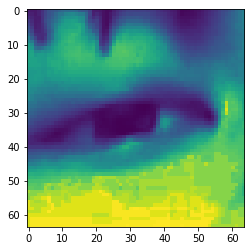

In [9]:
import matplotlib.pyplot as plt

def img2tensor(eye_image):
    tensor_input = eye_image.astype(np.float32)
    tensor_input *= 2.0 / 255.0
    tensor_input -= 1.0
    tensor_input = np.expand_dims(tensor_input, 0)
    tensor_input = torch.FloatTensor([tensor_input])
    return tensor_input

tensor_input = img2tensor(left_eye)
ear, fea_maps = model(tensor_input)
print(ear[0][2])
print(len(fea_maps))
plt.imshow(left_eye)


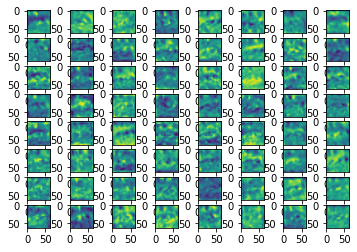

In [19]:
# for fea in fea_maps:
    # print(fea.shape)

heat = fea_maps[0]
fig, ax = plt.subplots(8,8)
ax = ax.flatten()
for i, h in enumerate(heat.detach().numpy()[0]):
    h = cv2.resize(h, (64, 64))
    ax[i].imshow(h)

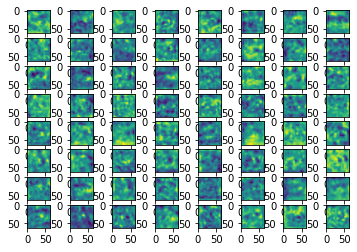

In [20]:
# for fea in fea_maps:
    # print(fea.shape)

heat = fea_maps[3]
fig, ax = plt.subplots(8,8)
ax = ax.flatten()
for i, h in enumerate(heat.detach().numpy()[0]):
    h = cv2.resize(h, (64, 64))
    ax[i].imshow(h)

tensor(0.2739, grad_fn=<SelectBackward>)


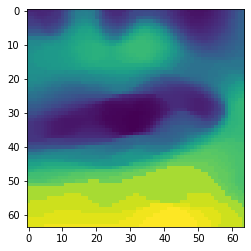

In [33]:
left_eye1 = cv2.medianBlur(left_eye, 9)
tensor_input = img2tensor(left_eye1)
ear = model(tensor_input)[0][2]
print(ear)
plt.imshow(left_eye1)

In [35]:
model

PFLDInference(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [64]:
from torch import nn

conv1 = model.conv1

outputs = conv1(tensor_input)


torch.Size([1, 64, 32, 32])


In [59]:
for name, param in model.conv3_1.conv.named_parameters():
    print(name, param.size())

0.weight torch.Size([128, 64, 1, 1])
1.weight torch.Size([128])
1.bias torch.Size([128])
3.weight torch.Size([128, 1, 3, 3])
4.weight torch.Size([128])
4.bias torch.Size([128])
6.weight torch.Size([64, 128, 1, 1])
7.weight torch.Size([64])
7.bias torch.Size([64])


In [60]:
 model.conv3_1.conv

Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)